In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib.request
import os
import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [1]:
import gzip
dirs = os.listdir('/Users/Desktop/Capstone/Safegraph/')
dfList = []
for index, filename in enumerate(dirs):
    if 'NY-PATTERNS' in filename:
        path = '/Users/Desktop/Capstone/Safegraph/' + filename
        if index == 0:
            with gzip.open('patterns.csv.gz', 'rt') as f:
            df = pd.read_csv(path+'/patterns.csv.gz', compression='gzip', index_col=None)
        else:
            df = pd.read_csv(path+'/patterns.csv.gz', compression='gzip', index_col=None, header=0)
        dfList.append(df)
dfPOI = pd.concat(dfList, axis=0, ignore_index=True)

In [3]:
#dfPOI = pd.to_csv('safegraph_data.csv')
#dfPOI = pd.read_csv('safegraph_data.csv')
dfPOI = dfPOI[dfPOI.postal_code!=11210]  # filter out zipcode 11210 (not in research sites)

In [5]:
dfPOI.reset_index(drop=False, inplace =True)
dfPOI.head()

,index,placekey,location_name,brands,top_category,sub_category,latitude,longitude,city,postal_code,opened_on,closed_on,raw_visit_counts,raw_visitor_counts,visitor_daytime_cbgs,month,month_num
0,0,zzy-223@627-wc7-st9,The Alley LuJiaoXiang,NaN,Restaurants and Other Eating Places,Snack and Nonalcoholic Beverage Bars,40.729621,-73.991264,New York,10003,NaN,NaN,969.0,786.0,"{""360610057002"":17,""360610049001"":11,""36061005...",2019_01,1
1,1,zzw-225@627-s8k-qs5,Mayahuel Mariposa,NaN,Restaurants and Other Eating Places,Full-Service Restaurants,40.727036,-73.988199,New York,10003,NaN,NaN,13.0,13.0,"{""360610063001"":4,""360610057002"":4}",2019_01,1
2,2,zzw-229@627-s8h-vs5,Eataly,Eataly,Restaurants and Other Eating Places,Full-Service Restaurants,40.741972,-73.990055,New York,10010,NaN,NaN,712.0,463.0,"{""360610058001"":36,""120860090381"":7,""340210043...",2019_01,1
3,3,22y-222@627-s8j-3kf,KFC,KFC,Restaurants and Other Eating Places,Limited-Service Restaurants,40.732227,-73.985306,New York,10003,NaN,NaN,641.0,394.0,"{""360470588002"":7,""360610050004"":7,""3604701930...",2019_01,1
4,4,22d-224@627-s8h-whq,Godiva Cafe,NaN,Restaurants and Other Eating Places,Snack and Nonalcoholic Beverage Bars,40.740358,-73.989665,New York,10010,NaN,NaN,502.0,367.0,"{""360610056003"":19,""360610058001"":9,""361031224...",2019_01,1


In [6]:
dfPOI.columns

Index(['index', 'placekey', 'location_name', 'brands', 'top_category',
       'sub_category', 'latitude', 'longitude', 'city', 'postal_code',
       'opened_on', 'closed_on', 'raw_visit_counts', 'raw_visitor_counts',
       'visitor_daytime_cbgs', 'month', 'month_num'],
      dtype='object')

In [8]:
# define a func to count the number of visitors from the column "visitor_daytime_cbgs" . PS. closed poi only have info in field "visitor_daytime_cbgs" , so this field can be used to compare closed poi & open poi
def visitor_counts(record):
    
    if str(record['visitor_daytime_cbgs'].values[0])=='nan':
        counts = 0
        
    else:
        visitor_record = np.array(record['visitor_daytime_cbgs'])
        visitor_lst = visitor_record[0][1:-1].split(',')
        dic = {}
        
        for st in visitor_lst:   
            key = st[1:13]
            value = st[15:]
            dic.update({key:value})
            
        for key in list(dic.keys()):       # remove nan value
            if not dic.get(key):
                del dic[key]
        
        counts = pd.Series(dic).astype('int').sum()
        
    return (counts)

In [9]:
# calculate visitor_counts for each record
for i in range(len(dfPOI)):
    record = dfPOI[dfPOI.index==i]
    dfPOI.loc[i,['visitor_cal']] = visitor_counts(record)

# Define and filter small businesses

In [14]:
# no brands for small businesses
dfPOI_s = dfPOI[dfPOI.brands.isnull()]
len(dfPOI_s)

66700

In [15]:
# check if the name of these businesses appeared at least twice
namelst = list(dfPOI_s.location_name.unique())
for name in namelst:
    if len(dfPOI_s[dfPOI_s.location_name == name]['placekey'].unique()) != 1:
        namelst.remove(name)
dfPOI_s = dfPOI_s[dfPOI_s.location_name.isin(namelst)]
len(dfPOI_s)

63452

# Temporary analysis

In [4]:
# define a function to rename Mark column
def Mark_to_Date(x):
    if x <= 12:
        month = x
        return (pd.to_datetime('%i/2019'%month))
    elif (x>=13) & (x <=24):
        month = x-12
        return (pd.to_datetime('%i/2020'%month))
    else:
        month = x-24
        return (pd.to_datetime('%i/2021'%month))

In [1]:
dfPOI_s['MonthYear'] = dfPOI_s['month_num'].apply(lambda x:Mark_to_Date(x))

In [2]:
# Average Number of Visitors
plt.figure(figsize=(15,5))
plt.title('Avg Visitors', fontsize=20)
dfPOI_s.groupby('MonthYear').mean()['visitor_cal'].plot()

In [41]:
# Before VS After COVID
dfPOI_a = dfPOI_s[dfPOI_s.MonthYear<=pd.to_datetime('02/01/2020')] # records before covid-19
dfPOI_b = dfPOI_s[dfPOI_s.MonthYear>=pd.to_datetime('03/01/2020')] # records after covid-19

In [42]:
# Calculate avg visitors for each store
POI_a_visitors = dfPOI_a.groupby('placekey').mean()['visitor_cal']
POI_b_visitors = dfPOI_b.groupby('placekey').mean()['visitor_cal']

In [43]:
# Merge data
dfPOI_a_visitors = dfPOI_a.merge(POI_a_visitors, left_on='placekey',right_on='placekey',how='left')
dfPOI_b_visitors = dfPOI_b.merge(POI_b_visitors, left_on='placekey',right_on='placekey',how='left')
dfPOI_a_visitors.drop_duplicates(subset='placekey', keep='first', inplace=True)
dfPOI_b_visitors.drop_duplicates(subset='placekey', keep='first', inplace=True)

In [44]:
# Export to csv
dfPOI_a_visitors.to_csv('Before_visitors.csv')
dfPOI_b_visitors.to_csv('After_visitors.csv')

In [45]:
dfPOI_s.sub_category.unique()

array(['Snack and Nonalcoholic Beverage Bars', 'Full-Service Restaurants',
       'Supermarkets and Other Grocery (except Convenience) Stores',
       'Limited-Service Restaurants', 'Convenience Stores'], dtype=object)

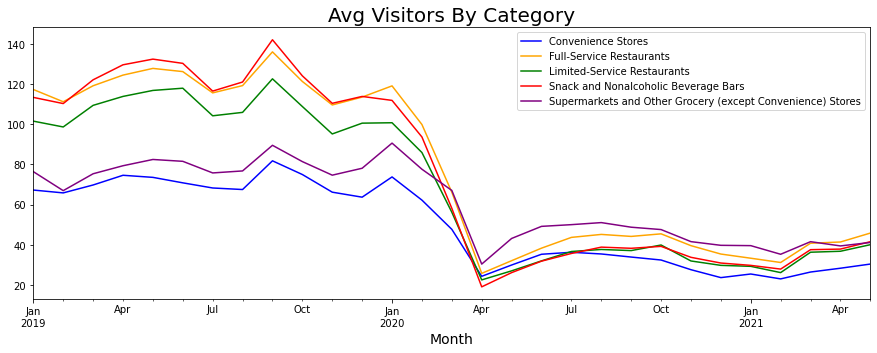

In [59]:
# Average Number of Visitors by Category
plt.figure(figsize=(15,5))
plt.title('Avg Visitors By Category', fontsize=20)
dfPOI_s[dfPOI_s.sub_category=='Convenience Stores'].groupby('MonthYear').mean()['visitor_cal'].plot(label='Convenience Stores', color='b')
dfPOI_s[dfPOI_s.sub_category=='Full-Service Restaurants'].groupby('MonthYear').mean()['visitor_cal'].plot(label='Full-Service Restaurants', color='orange')
dfPOI_s[dfPOI_s.sub_category=='Limited-Service Restaurants'].groupby('MonthYear').mean()['visitor_cal'].plot(label='Limited-Service Restaurants', color='green')
dfPOI_s[dfPOI_s.sub_category=='Snack and Nonalcoholic Beverage Bars'].groupby('MonthYear').mean()['visitor_cal'].plot(label='Snack and Nonalcoholic Beverage Bars', color='r')
dfPOI_s[dfPOI_s.sub_category=='Supermarkets and Other Grocery (except Convenience) Stores'].groupby('MonthYear').mean()['visitor_cal'].plot(label='Supermarkets and Other Grocery (except Convenience) Stores', color='purple')
plt.xlabel('Month', fontsize=14)
#plt.ylabel('Number of POI', fontsize=14)
plt.legend()

In [17]:
# closed poi
POI_close = dfPOI_s[dfPOI_s.closed_on.notna()]
POI_close['closed_on'] = pd.to_datetime(POI_close['closed_on'])
POI_close.drop_duplicates(subset='placekey', keep='first', inplace=True)
df_close = POI_close.groupby('closed_on').count()['placekey']

In [49]:
df_close

closed_on
2019-07-01      2
2019-09-01      1
2019-12-01      2
2020-01-01    437
2020-02-01     15
2020-07-01     33
2020-08-01     29
2020-10-01     15
2020-11-01      1
2020-12-01      1
2021-04-01      1
2021-05-01      1
Name: placekey, dtype: int64

In [51]:
POI_close[['sub_category','placekey']].groupby(by=['sub_category']).count()

,placekey
sub_category,
Convenience Stores,11
Full-Service Restaurants,356
Limited-Service Restaurants,70
Snack and Nonalcoholic Beverage Bars,74
Supermarkets and Other Grocery (except Convenience) Stores,27


In [52]:
# compare closed POI and open POI
POI_close = dfPOI_s[dfPOI_s.closed_on.notna()]
POI_open = dfPOI_s[dfPOI_s.closed_on.isnull()]
POI_close['closed_on'] = pd.to_datetime(POI_close['closed_on'])

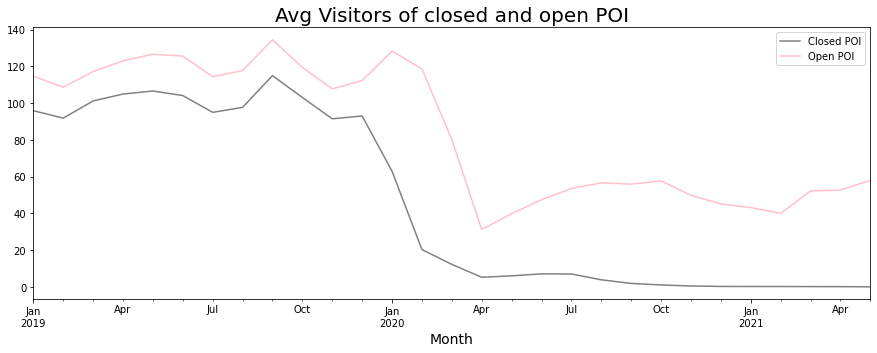

In [58]:
plt.figure(figsize=(15,5))
plt.title('Avg Visitors of closed and open POI', fontsize=20)
POI_close.groupby('MonthYear').mean()['visitor_cal'].plot(label='Closed POI',color='grey')
POI_open.groupby('MonthYear').mean()['visitor_cal'].plot(label='Open POI',color='pink')
plt.xlabel('Month', fontsize=14)
#plt.ylabel('Number of POI', fontsize=14)
plt.legend()

In [54]:
# compare closed POI before vs after covid
POI_close_a = POI_close[POI_close.closed_on<=pd.to_datetime('02/01/2020')] # records before covid-19
POI_close_b = POI_close[POI_close.closed_on>=pd.to_datetime('03/01/2020')] # records after covid-19

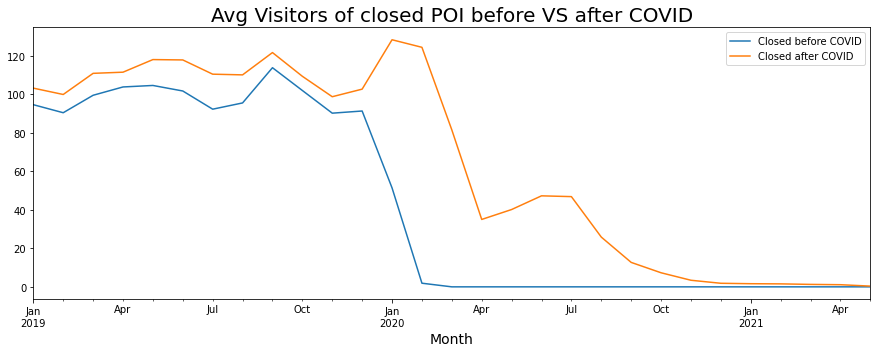

In [61]:
plt.figure(figsize=(15,5))
plt.title('Avg Visitors of closed POI before VS after COVID', fontsize=20)
POI_close_a.groupby('MonthYear').mean()['visitor_cal'].plot(label='Closed before COVID')
POI_close_b.groupby('MonthYear').mean()['visitor_cal'].plot(label='Closed after COVID')
plt.xlabel('Month', fontsize=14)
#plt.ylabel('Number of POI', fontsize=14)
plt.legend()